In [89]:
import numpy as np

In [90]:
dataset = './data/landmarks.csv'
model_save_path = './models/classifier.keras'

In [91]:
X = np.loadtxt(dataset, delimiter=',', dtype="float32", usecols=list(range(1, (21 * 2) + 1)))
X.shape

(63744, 42)

In [92]:
Y = np.loadtxt(dataset, delimiter=',', dtype="int32", usecols=(0))
print(Y.shape)

num_classes = np.max(Y) + 1
print("Number of classes:", num_classes)

(63744,)
Number of classes: 28


In [125]:
unique, counts = np.unique(Y, return_counts=True)

print(counts)

[2517 2209 2176 2538 1987 1290 2341 2309 2023 2564 2392 2493 2405 2879
 2438 1656 2068 2350 2532 2275 2176 2430 2553 2566 1589 2697 2508 1783]


In [93]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=827)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=827)

print(f"Training data amount: {len(X_train)}")
print(f"Testing data amount: {len(X_test)}")
print(f"Validation data amount: {len(X_val)}")

Training data amount: 38246
Testing data amount: 12749
Validation data amount: 12749


In [94]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [99]:
import tensorflow as tf
from scipy.sparse import issparse

def train_model(model, X, Y, X_val, Y_val):
    with tf.device("/gpu:0"):
        if issparse(X):
            X = X.toarray()
        if issparse(Y):
            Y = Y.toarray()
        if issparse(X_val):
            X_val = X_val.toarray()
        if issparse(Y_val):
            Y_val = Y_val.toarray()
        
        X = np.asarray(X)
        Y = np.asarray(Y).astype("int64")
        X_val = np.asarray(X_val)
        Y_val = np.asarray(Y_val).astype("int64")

        model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy']
        )
        
        callbacks = [
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.1,
                patience=3,
                min_delta=1e-3,
                min_lr=1e-10
            ),
            tf.keras.callbacks.ModelCheckpoint(
                f'{model_save_path}',
                save_best_only=True,
                monitor='val_accuracy'
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=20,
                min_delta=0.001,
                mode='min'
            )
        ]


        history = model.fit(
            X,
            Y,
            validation_data=(X_val, Y_val),
            batch_size=1024,
            epochs=1000,
            callbacks=callbacks,
        )

        return history

In [118]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(64),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(32),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()


/home/beebadoobee/code/asl-detection/venv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_49          │ (None, 42)             │           168 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 64)             │         2,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 28)             │           924 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,308 (24.64 KB)

 Trainable params: 6,032 (23.56 KB)

 Non-trainable params: 276 (1.08 KB)

In [119]:
train_model(model, X=X_train, Y=y_train, X_val=X_val, Y_val=y_val)

Epoch 1/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.0998 - loss: 3.5135 - val_accuracy: 0.2123 - val_loss: 2.9274 - learning_rate: 0.0010
Epoch 2/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3172 - loss: 2.3525 - val_accuracy: 0.4907 - val_loss: 2.4613 - learning_rate: 0.0010
Epoch 3/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4629 - loss: 1.8502 - val_accuracy: 0.7185 - val_loss: 1.9247 - learning_rate: 0.0010
Epoch 4/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5658 - loss: 1.5151 - val_accuracy: 0.8091 - val_loss: 1.4052 - learning_rate: 0.0010
Epoch 5/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6232 - loss: 1.2972 - val_accuracy: 0.8507 - val_loss: 1.0072 - learning_rate: 0.0010
Epoch 6/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6691 - loss: 1.1283 - val_accuracy: 0.8994 - val_loss: 0.7451 - learning_rate: 0.0010
Epoch 7/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6999 - loss: 1.0134 -

In [120]:
model = tf.keras.models.load_model(f"./{model_save_path}")

In [121]:
model.evaluate(X_test, y_test)

399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9740 - loss: 0.1534


[0.16723351180553436, 0.9722331166267395]

## Confusion Matrix

399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


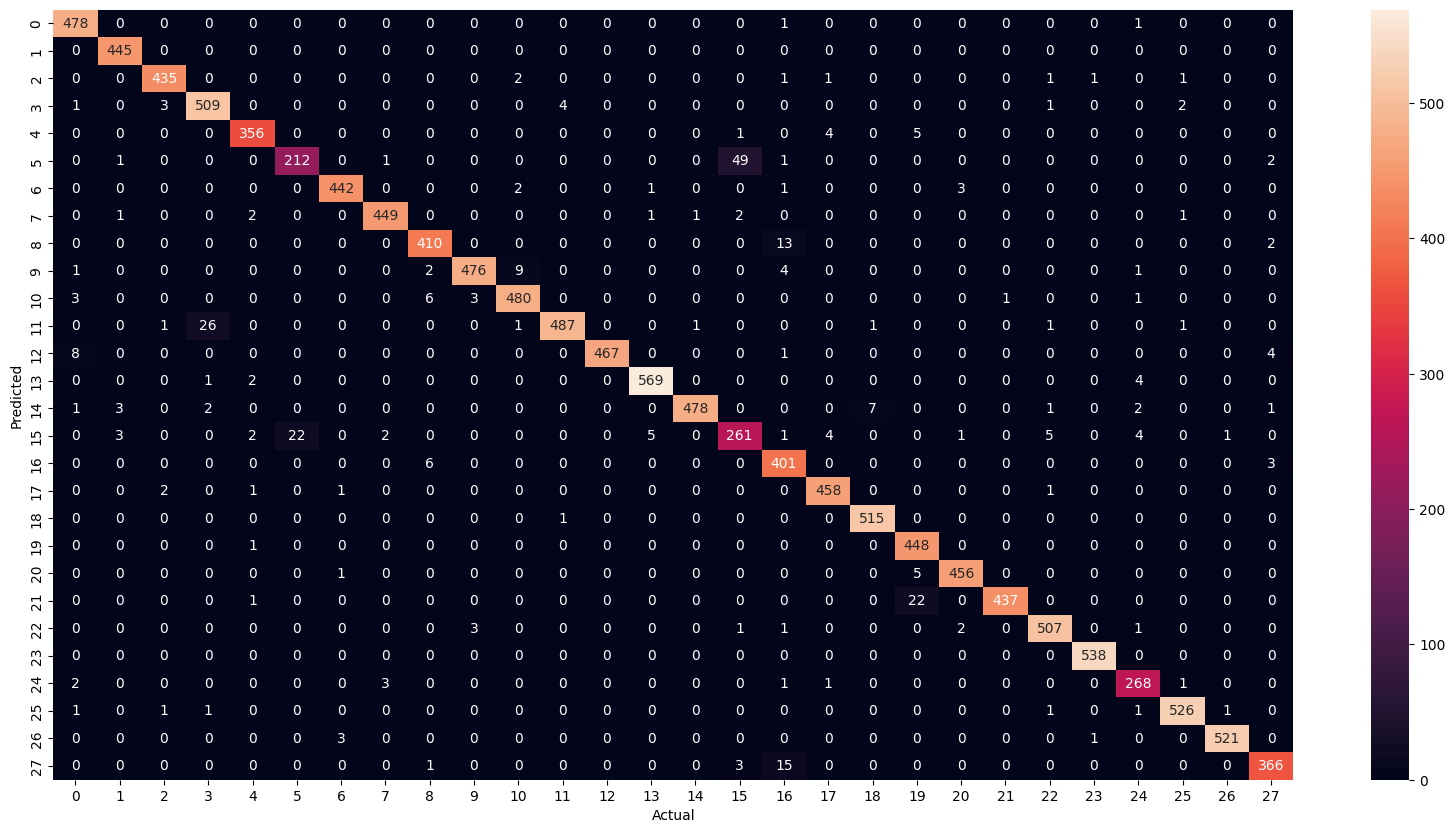

In [123]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(20, 10))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    
    plt.xlabel("Actual")
    plt.ylabel("Predicted")

    plt.show()

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)